### Ë¶≥Ê∏¨„Éá„Éº„Çø
Ëß£Êûê„Å´ÂøÖË¶Å„Å™„Éá„Éº„Çø
- XFFTS data
- Encoder data
- weather status
- hosei copy
- obs copy

‰∏≠ÈñìÁîüÊàê„Éá„Éº„Çø
- encoder npy
- xffts npy
- vobs npy

### Ëß£Êûê„Éï„É≠„Éº

- doppler tracking[o]
     - XFFTS„ÅÆtimestamp„Å®Ra, Dec„ÅÆÊÉÖÂ†±„Åã„Çâvobs„ÇíË®àÁÆó„Åó„Åæ„Åô„ÄÇ
     - vobs„ÅÆÈáè„Å†„Åëch„Çí„Åö„Çâ„Åó„Åæ„Åô„ÄÇ(Â∞èÊï∞ch„ÅÆ„Åö„Çå„ÅØÁ∑öÂΩ¢Ë£úÂÆå„ÅßË®àÁÆó„Åó„Å¶„Åö„Çâ„Åó„Åæ„Åô)
- Chopper Wheel [o]
- baseline fitting [o]
- Scaling(from standard object?) [x]
- regrid [o]
    - rms [o]
    - distance [o]
- +header [o]
- 3d-fits[o]

In [64]:
import sys
sys.path.append("../script/")
import time
import subprocess
import os
import numpy
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import numba
from astropy.io import fits
from scipy import interpolate
import glob
###‰ª•‰∏ãÁã¨Ëá™
import n2df
import read_obsfile
import analy_doppler_nanten
import log_weather

In [65]:
analy_dir = "/home/amigos/data/otf_2019/n20190904142646_12CO_2-1_otf_OriKL"#Êñ∞ÂΩ¢Âºè
subprocess.getoutput(["ls {}".format(analy_dir)]).split("\n")

['enc.db',
 'encoder_radec.npy',
 'hosei_230.txt',
 'line_otf_OriKL_dcosy.obs',
 'test20190905.fits',
 'test20190906.fits',
 'test20190906_v2.fits',
 'test20190906_v3.fits',
 'test20190906_v5.fits',
 'test20190906_v6.fits',
 'test20190906_v8.fits',
 'test20190906_v.fits',
 'test4.fits',
 'vobs.npy',
 'weather.csv',
 'xffts.ndf',
 'xffts_radec.npy']

In [66]:
###Ê∞óË±°ÊÉÖÂ†±„ÅÆË™≠„ÅøËæº„Åø
weather_data = log_weather.Weather_log(os.path.join(analy_dir, "weather.csv")).read()
print(weather_data)
#Ê∞óË±°„Éá„Éº„Çø„ÅÆÁ¢∫Ë™ç
humi = numpy.mean(weather_data["outhumi"])
press = numpy.mean(weather_data["press"])
temprature = numpy.mean(weather_data["outtemp"])
lamda = 1300
cabin_temp = weather_data["cabin_temp1"] + 273

      timestamp     intemp    outtemp    inhumi   outhumi     winddir  \
0  1.567607e+09  15.165850  16.762726  1.233124  8.473565  268.908455   
1  1.567607e+09  14.549850  16.380080  1.769449  8.764045  268.062679   
2  1.567607e+09  14.352203  16.540349  1.371281  8.939968  268.232077   
3  1.567607e+09  14.832550  16.516944  1.410851  8.499712  268.703383   
4  1.567607e+09  15.014435  16.310218  1.383554  8.001146  268.403536   
5  1.567607e+09  15.227496  16.502959  1.787469  8.020369  268.405620   
6  1.567607e+09  14.941033  16.210031  1.054588  8.859497  268.497477   
7  1.567607e+09  15.312008  16.305998  1.351483  8.623849  268.810436   
8  1.567607e+09  14.806064  16.560436  1.701079  8.045723  268.784821   

     windsp       press      rain  cabin_temp1  cabin_temp2  dome_temp1  \
0  6.788000  570.449484  0.367690    21.823577    31.744922    9.926390   
1  6.283264  570.372420  0.431126    22.097574    32.098455   10.393100   
2  5.868241  570.252858  0.744092    21.7187

In [67]:
%%time
if not os.path.exists(os.path.join(analy_dir, "xffts_radec.npy")):
    cmd = "python /home/amigos/git/analy_n2data/script/analy_coordinates.py {analy_dir} -p {press} -l {lamda} -hu  {humi} -t {temprature}".format(**locals())
    subprocess.run(cmd.split())

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 309 ¬µs


In [68]:
###AzElÊÉÖÂ†±„Çíradec„Å´Â§âÊèõ„Åó„Åü„ÇÇ„ÅÆ„ÅÆ‰∏ÄÊôÇ„Éï„Ç°„Ç§„É´„ÅÆË™≠„ÅøËæº„Åø
path_xffts_c = os.path.join(analy_dir, "xffts_radec.npy")
path_encoder_c = os.path.join(analy_dir, "encoder_radec.npy")
xffts = numpy.load(path_xffts_c)
encoder = numpy.load(path_encoder_c)

### grid„ÅÆ‰ΩúÊàê


In [69]:
#Ë¶≥Ê∏¨„Éó„É≠„Ç∞„É©„É†„Åã„ÇâÂøÖË¶Å„Å™ÊÉÖÂ†±„ÇíÂá∫„Åô
obspath = glob.glob(analy_dir+"/*obs")
obs = read_obsfile.read(obspath[0])
lamda_on = obs["lambda_on"]
beta_on = obs["beta_on"]
N = obs["N"]
grid = obs["grid"]/3600 #[deg]

In [70]:
obs

{'N': 9,
 'acc': 10,
 'beta_off': -5.6683,
 'beta_on': -5.37432,
 'betdel_off': 0,
 'cold_flag': 'N',
 'coordsys': 'j2000',
 'cosydel': 'j2000',
 'datanum': 9.0,
 'end_ch_1': 16383,
 'end_ch_2': 16383,
 'exposure': 0.6,
 'exposure_off': 10.0,
 'fpga_integtime': 100,
 'grid': 30,
 'if1st_freq_1': 4438.0,
 'if1st_freq_2': 5701.3,
 'if3rd_freq_1': 500.0,
 'if3rd_freq_2': 500.0,
 'lambda_off': 82.559,
 'lambda_on': 83.80613,
 'lamdel_off': 0,
 'lamp_pixels': 4,
 'lo1st_sb_1': 'U',
 'lo1st_sb_2': 'L',
 'lo2nd_sb_1': 'L',
 'lo2nd_sb_2': 'L',
 'lo3rd_freq_1': 4100.0,
 'lo3rd_freq_2': 4100.0,
 'lo3rd_sb_1': 'L',
 'lo3rd_sb_2': 'L',
 'load_interval': 5,
 'molecule_1': '12CO',
 'molecule_2': '13CO',
 'multiple': 12,
 'nTest': 1,
 'object': 'OriKL',
 'observer': 'amigos',
 'obsfreq_1': 230538.0,
 'obsfreq_2': 220398.684,
 'obsmode': 'LINEOTF',
 'offset_Az': 0,
 'offset_El': 0,
 'otadel': 'N',
 'otadel_off': 'N',
 'otflen': 5.4,
 'otfvel': 50.0,
 'pllharmonic': 1,
 'pllref_if': 1,
 'pllreffreq': 0

In [71]:
#‰ªäÂõûgird„Åã„Çâ„Å©„Åì„Åæ„ÅßÈõ¢„Çå„ÅüÁØÑÂõ≤„Åæ„ÅßËß£Êûê„ÅÆ‰∏≠„Å´Âê´„ÇÅ„Çã„Åã„ÅÆÂÄ§„ÄÇ„Åì„Çå„ÅØÂ§ñ„Åã„Çâ„ÅÑ„Åò„Çå„ÇãÂÄ§„Å´„Åó„Å¶„Åä„Åã„Å™„ÅÑ„Å®
offset = 80#ÂçäÂæÑ[arcsec]
array_num = 2#1~16IF 

In [72]:
#make gird
ragrid = numpy.linspace(lamda_on - ((N-1)/2)*grid, lamda_on + ((N-1)/2)*grid, num=9)
decgrid = numpy.linspace(beta_on - ((N-1)/2)*grid, beta_on + ((N-1)/2)*grid, num=9)
radec_grid = numpy.meshgrid(ragrid, decgrid)
numpy.shape(radec_grid)

(2, 9, 9)

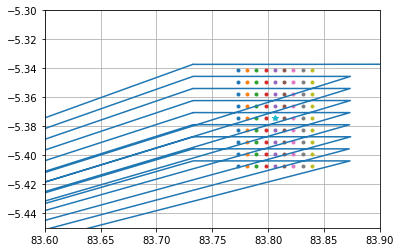

In [73]:
#grid„ÅÆÁ¢∫Ë™ç
#gird„Å®XFFTS„ÅÆÁÇπ„Åå„Åö„Çå„Å¶„ÅÑ„Çã„ÄÇ
plt.plot(radec_grid[0], radec_grid[1], ".")
plt.plot(lamda_on, beta_on, "*")
plt.plot(xffts[0], xffts[1])
#plt.plot(encoder[0], encoder[1], ".")
plt.xlim(83.6, 83.9)
plt.ylim(-5.45, -5.3)
plt.savefig("neko.pdf")
plt.grid()
plt.show()

### „Å™„Çì„ÅßÁ∑ö„Å®ÁÇπ„Åå„Åö„Çå„Å¶„ÅÑ„Çã„Çì„Å†Ôºü

In [74]:
%%time
#ÂàÜÂÖâ„Éá„Éº„Çø„ÅÆË™≠„ÅøÂá∫„Åó
n = n2df.Read(os.path.join(analy_dir, "xffts.ndf"))
array_data = n.read_onearray(array_num)#1IF„ÅÆÂàÜÂÖâ„Éá„Éº„Çø
obs_mode = n.read_obs_mode()#Ë¶≥Ê∏¨„É¢„Éº„ÉâÔºàON/OFF/HOTÔºâ
scan_num = n.read_scan_num()#„Çπ„Ç≠„É£„É≥„É©„Ç§„É≥Ôºà0,1,2,3,4,...Ôºâ
###array_data, scan_num, obs_mode = n.read_for_otf(1)#3ÂàÜ„Åè„Çâ„ÅÑ„Åã„Åã„Åü

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2146/2146 [00:00<00:00, 296299.18it/s]

CPU times: user 40 ms, sys: 92 ms, total: 132 ms
Wall time: 153 ms


## doppler tracking


In [75]:
if not os.path.exists(os.path.join(analy_dir, "vobs.npy")):
    from numpy import deg2rad
    d = analy_doppler_nanten.doppler_nanten()
    vobs = [d.calc_vobs(deg2rad(xffts[0][i]),deg2rad(xffts[1][i]), xffts[2][i]) for i in tqdm(range(len(xffts[0])))]
    numpy.save(os.path.join(analy_dir, "vobs"), vobs)
    # joblib version
    #vobs = Parallel(n_jobs=-1, verbose=2)([delayed(d.calc_vobs(deg2rad(xffts[0][i]), deg2rad(xffts[1][i]), xffts[2][i])) for i in tqdm(range(len(xffts[0])))])
else:
    print(" vobs.npy already exists")

 vobs.npy already exists


In [76]:
vobs = numpy.load(os.path.join(analy_dir, "./vobs.npy"))
vobs += 5
# For debug
if numpy.count_nonzero(vobs>0) == len(vobs):
    print("vobs„ÅØÂÖ®„Å¶Ê≠£")
elif numpy.count_nonzero(vobs<0) == len(vobs):
    print("vobs„ÅØÂÖ®„Å¶Ë≤†")
else:
    print("vobs„ÅØÊ≠£„ÇÇË≤†„ÇÇ„ÅÇ„Çã")

# config
dv = 0.167#km/s
ch = numpy.linspace(0, 32767, 32768)
bch = list(map(int, vobs//dv))#chÊï∞„ÅÆÁßªÂãï
slide_ch = (vobs/dv) - bch#interpolation„Å´„Çà„ÇãÁßªÂãïÈáè

dp_data = []
xx_data = []
for i in tqdm(range(len(vobs))):
    f = interpolate.interp1d(ch, array_data[i])
    ch2 = ch+slide_ch[i]
    if slide_ch[i] > 0:
        n = f(ch2[:-1])
    elif slide_ch[i] <0:
        n = f(ch2[1:])
    new_p = n
    xx = ch[:-1] - bch[i]
    yy = new_p
    xx_data.append(xx)
    dp_data.append(yy)
    
xx_data = numpy.array(xx_data)
xx_min = numpy.max(xx_data.T[0])#regrid„ÅÆÊúÄÂ∞èÂÄ§
xx_max = numpy.min(xx_data.T[-1])#regird„ÅÆÊúÄÂ§ßÂÄ§

new_xx = numpy.arange(xx_min, xx_max+1, 1)
print(new_xx, len(new_xx))
vlen = len(new_xx)

mask_list= []
for i in range(len(xx_data)):
    mask = (xx_data[i] >= xx_min) & (xx_data[i] <= xx_max)
    mask_list.append(mask)
    
new_yy_list = []
for i in tqdm(range(len(xx_data))):
    new_yy_list.append(dp_data[i][mask_list[i]])
    
len(new_xx)
origin_array_data = array_data
array_data = new_yy_list
numpy.shape(array_data)

  2%|‚ñè         | 38/2146 [00:00<00:05, 374.07it/s]

vobs„ÅØÂÖ®„Å¶Ê≠£


  0%|          | 0/2146 [00:00<?, ?it/s]

[-1272. -1271. -1270. ... 31491. 31492. 31493.] 32766


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2146/2146 [00:00<00:00, 11293.10it/s]


(2146, 32766)

(8000, 8100)

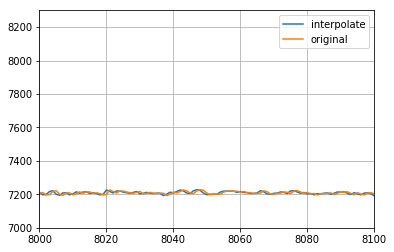

In [77]:
%matplotlib inline
plt.plot(new_yy_list[0], label="interpolate")
plt.plot(origin_array_data[0], label="original")
plt.legend()
plt.grid()
plt.ylim(7000,8300)
plt.xlim(8000,8100)
#plt.ylim(7100, 7200)


on/off/hot index„ÅÆÊï¥ÁêÜ

In [78]:
###indexÊé¢„Åó
obs_mode = numpy.array(obs_mode)
scan_num = numpy.array(scan_num)

offmask = obs_mode == "OFF"
offindex = numpy.where(offmask == True)

hotmask = obs_mode == "HOT"
hotindex = numpy.where(hotmask == True)

onmask = obs_mode == "ON"
onindex = numpy.where(onmask == True)

max_scannum = numpy.max(scan_num)#Caution! scan num starts from 0, so scan number of 26 indicates 27 times scan

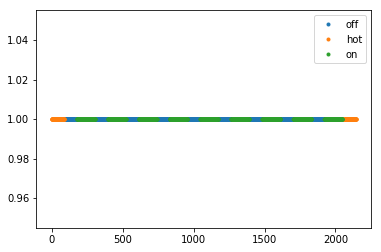

In [79]:
#‰∏ÄÂøúindex„ÅÆÂèØË¶ñÂåñ
plt.plot(offindex[0], [1]*len(offindex[0]),"." , label = "off")
plt.plot(hotindex[0], [1]*len(hotindex[0]),"." , label = "hot")
plt.plot(onindex[0], [1]*len(onindex[0]),"." , label = "on")
# plt.xlim(0,1000)
plt.legend()
plt.show()

[0 0 0 ... 9 9 9]


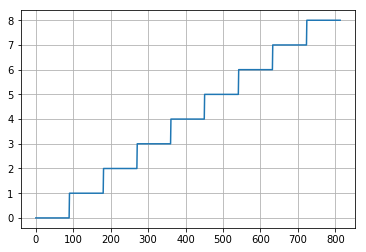

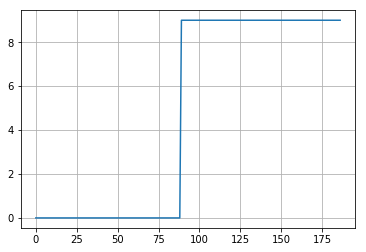

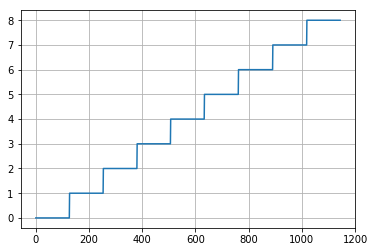

In [80]:
#OFF ÁÇπ„ÅÆscan number „ÇíÂèñÂæó
scan_num = numpy.array(scan_num)
print(scan_num)
offindex[0]
plt.plot(scan_num[offindex[0]])
plt.grid()
plt.show()

#HOT ÁÇπ„ÅÆscan number „ÇíÂèñÂæó
scan_num = numpy.array(scan_num)
hotindex[0]
plt.plot(scan_num[hotindex[0]])
plt.grid()
plt.show()

# ON ÁÇπ„ÅÆscan number „ÇíÂèñÂæó
scan_num = numpy.array(scan_num)
plt.plot(scan_num[onindex[0]])
plt.grid()
plt.show()

### hot/off„ÅÆÁ©çÂàÜ

In [18]:
len(array_data)

2146

In [19]:
#HOTÁ©çÂàÜ
print(numpy.unique(scan_num[hotindex[0]]))#HOT „ÅÆscan number
hotnum = numpy.unique(scan_num[hotindex[0]])#HOT„ÅÆÊï∞

hotdata = []

for i in tqdm(hotnum):#i = scan number
    mask = scan_num == i#ÁâπÂÆö„ÅÆscannum„ÅÆindex„ÇíÊäú„ÅçÂá∫„Åô
    index = numpy.where(mask == True)#ÁâπÂÆö„ÅÆscannum„ÅÆindexÂ§âÊï∞
   ### 
    c = numpy.in1d(index[0], hotindex[0])#ÁâπÂÆö„ÅÆscannum„ÅÆindex&HOT index
    c = numpy.where(c == True)[0]
    ###
    mm = index[0][c]#scan num„ÅÆÂÄ§„Åß„Éï„Ç£„É´„Çø„Éº„Åó„Åühot
    print(mm)
    ###Á©çÂàÜ
    tmp = [array_data[j] for j in mm]
    hotdata.append(sum(tmp)/len(tmp))
    pass


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00, 209.09it/s]

[0 9]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88]
[2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061
 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075
 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089
 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 2101 2102 2103
 2104 2105 2106 2107 2108 2109 2110 2111 2112 2113 2114 2115 2116 2117
 2118 2119 2120 2121 2122 2123 2124 2125 2126 2127 2128 2129 2130 2131
 2132 2133 2134 2135 2136 2137 2138 2139 2140 2141 2142 2143 2144 2145]


In [20]:
##OFF„ÅÆÁ©çÂàÜ
print(numpy.unique(scan_num[offindex[0]]))#HOT „ÅÆscan number
offnum = numpy.unique(scan_num[offindex[0]])#HOT„ÅÆÊï∞

offdata = []
scan_num = numpy.array(scan_num)

for i in tqdm(offnum):
    mask = scan_num == i#ÁâπÂÆö„ÅÆscannum„ÅÆindex„ÇíÊäú„ÅçÂá∫„Åô
    index = numpy.where(mask == True)#ÁâπÂÆö„ÅÆscannum„ÅÆindexÂ§âÊï∞
   ### 
    c = numpy.in1d(index[0], offindex[0])#ÁâπÂÆö„ÅÆscannum„ÅÆindex&HOT index
    c = numpy.where(c == True)[0]#scannum„Å®hot„ÅßÁµû„Å£„Åüindex
    mm = index[0][c]#scan num„ÅÆÂÄ§„Åß„Éï„Ç£„É´„Çø„Éº„Åó„Åühot
    tmp = [array_data[j] for j in mm]
    offdata.append(sum(tmp)/len(tmp))

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9/9 [00:00<00:00, 345.92it/s]

[0 1 2 3 4 5 6 7 8]


Hot „ÅÆ„Éá„Éº„Çø„ÅØscan lineÂàÜ„ÅÇ„Çã„Çè„Åë„Åß„Å™„ÅÑ„ÅÆ„ÅßË£úÂÆå
Off „ÇÇscan line ÂàÜ„ÅÇ„ÇãË¶≥Ê∏¨„Éó„É≠„Ç∞„É©„É†„Åó„Åã„Å™„ÅÑ„ÅØ„Åö„Å†„Åå„ÄÅ‰∏ÄÂøúË£úÂÆå

Ë£úÂÆå„ÅÆÊñπÊ≥ï„ÅØÊ¨°„ÅÆOFF/HOT„ÅÆÁÇπ„ÅÆË¶≥Ê∏¨„ÇíË°å„ÅÜ„Åæ„Åß„ÅØÁõ¥Ëøë„ÅÆ„Éá„Éº„Çø„ÇíÊé°Áî®„Åô„ÇãÂΩ¢

In [21]:
d = numpy.unique(scan_num[hotindex[0]])#HOT „ÅÆscan number
hotdata_ = []
count = 0

for i in tqdm(range(max_scannum)):
        #print(i,count, d[count])
        if i == d[count]:
            hotdata_.append(d[count])
            count +=1
        elif i < d[count]:
            hotdata_.append(d[count-1])
        else:#„Åì„ÅÆ‰æãÂ§ñ„Å´„ÅØÂÖ•„Çâ„Å™„ÅÑ„ÅØ„Åö
            print(i)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9/9 [00:00<00:00, 29285.29it/s]


In [22]:
d = numpy.unique(scan_num[offindex[0]])#HOT „ÅÆscan number
offdata_ = []
count = 0

for i in tqdm(range(max_scannum)):
        #print(i,count)
        if i == d[count]:
            offdata_.append(d[count])
            count +=1
        elif i < d[count]:
            offdata_.append(d[count-1])
        else:#„Åì„ÅÆ‰æãÂ§ñ„Å´„ÅØÂÖ•„Çâ„Å™„ÅÑ„ÅØ„Åö
            print(i)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9/9 [00:00<00:00, 47602.44it/s]


In [23]:
hotdata_

[0, 0, 0, 0, 0, 0, 0, 0, 0]

0
(10, 32766)


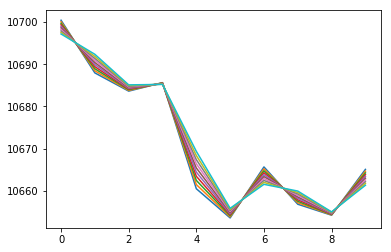

In [127]:
#hot „ÅÆÊñ∞„Åó„ÅÑ„ÇÑ„ÇäÊñπ
d = numpy.unique(scan_num[hotindex[0]])#HOT „ÅÆscan number
n_hotdata = []
for i in range(len(d)-1):
    print(i)
    a = (hotdata[i+1] - hotdata[i])/(d[i+1] - d[i])
    a = numpy.array(a)
    b = d[i+1] -d[i]
    x = numpy.linspace(0,b,b+1)
    for j in x:
        n_hotdata.append(a*j + hotdata[i])
    

n_hotdata = numpy.array(n_hotdata)
#plt.plot(n_hotdata.T[3])
print(numpy.shape(n_hotdata))
%matplotlib inline
plt.plot(n_hotdata.T[1000:1010])
plt.show()

In [81]:
# ###Choper wheel

@numba.jit
def chopper_wheel(on_index, scan_num, temprature = 300):    
    #scan_num = n[on_index]["scan_num"]
    Tastar = (array_data[on_index] - offdata[offdata_[scan_num]])/(hotdata[hotdata_[scan_num]] - offdata[offdata_[scan_num]]) * temprature
    #Tastar = (array_data[on_index] - offdata[0])/(hotdata[0] - offdata[0]) * temprature#test, this will be deletedÔºàhotdata, offdata[0]„Åó„Åã„Å§„Åã„Å£„Å¶„Å™„ÅÑÔºÅÔºâ
    return Tastar

def calc(i):#onÁÇπ„Çíscan index„Åßmask„Åóchopper wheel„Åô„Çã
    mask = scan_num == i#ÁâπÂÆö„ÅÆscannum„ÅÆindex„ÇíÊäú„ÅçÂá∫„Åô
    index = numpy.where(mask == True)#ÁâπÂÆö„ÅÆscannum„ÅÆindexÂ§âÊï∞
    c = numpy.intersect1d(index[0], onindex[0])
    return [[j, chopper_wheel(j, i, cabin_temp[i])] for j in c]###j= index 

In [82]:
ondata = [calc(i) for i in tqdm(range(max_scannum+1))]#Chopper Wheel„Åó„Åü„ÇÑ„Å§

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [00:01<00:00,  6.50it/s]


In [26]:
%%time
data_on = {ondata[i][j][0]:ondata[i][j][1] for i in range(len(ondata)) for j in range(len(ondata[i]))}###d[onindex] = onarray

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 192 ¬µs


In [27]:
#Ë∑ùÈõ¢„Å´„Çà„ÇãÈáç„Åø„Å§„ÅëÈñ¢Êï∞Ôºë
#sigma == „Éì„Éº„É†„Çµ„Ç§„Ç∫
def gauss(x, a = 1, mu = 0, sigma = 160):
    return a * numpy.exp(-(x - mu)**2 / (2*sigma**2))


#Ë∑ùÈõ¢„Å´„Çà„ÇãÈáç„Åø„Å§„ÅëÈñ¢Êï∞2 Èñ¢Êï∞Á≥ª„Çè„Åã„Çâ„Å™„ÅÑ„ÅÆ„Åß‰ªä„ÅØgaussian„Å†„Åë„Å©‰øÆÊ≠£
def bessel_gauss(x, a = 1, mu = 0, sigma = 160):
    return a * numpy.exp(-(x - mu)**2 / (2*sigma**2))

#ÁêÉÈù¢„Å™„ÅÆ„ÅßRAÊñπÂêë„ÅÆÈï∑„Åï„ÅåDEC„ÅßÂ§â„Çè„Çä„Åæ„Åô„ÄÇ„Å™„ÅÆ„ÅßRA-DECÂπ≥Èù¢„Åß„ÅÆË∑ùÈõ¢(ËßíÂ∫¶)„ÇíÂá∫„Åô„Å´„ÅØ„ÄÅRA„Çícos(DEC)„ÅßÂâ≤„ÇãÂøÖË¶Å„Åå„ÅÇ„Çä„Åæ„Åô„ÄÇ
def calc_distance(d1, d2):
    #d1 = [ra, dec] #deg   
    factor = 3600#„Åì„ÅÜ„ÅÑ„ÅÜ„Åì„Å®„Åó„Å™„Åè„Å¶„ÇÇ„ÅÑ„ÅÑ„Çà„ÅÜ„Å´astropy unit„Çí‰Ωø„ÅÜÔºàË¶ÅÁ∑®ÈõÜÔºâ
    d1[0] = d1[0]*factor
    d1[1] = d1[1]*factor
    d2[0] = d2[0]*factor
    d2[1] = d2[1]*factor
    return ((d1[0] - d2[0])**2 + (d1[1] - d2[1])**2)**0.5

def calc_rms(arr):
    return numpy.sqrt(numpy.mean(arr**2))

def rms_dist_weighting(arr, dist, rms):
    return [arr*gauss(dist)*(rms**-2), gauss(dist)*(rms**-2)]

## Baseline fitting

  3%|‚ñé         | 39/1145 [00:00<00:02, 384.83it/s]

3000 7500 8500 30000


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1145/1145 [00:02<00:00, 414.83it/s]


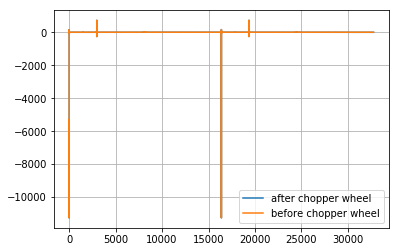

In [28]:
#baseline fitting parameter
center = 8000
width = 1000
start = 3000
end = 30000

#baseline fitting function
def f(x, a, b, c):
    return a*x**2 + b*x + c

def  baseline_fitting(arr_x, arr_y, index1, index2, index3, index4):
    tmpdata_y1 = arr_y[index1:index2]
    tmpdata_y2 = arr_y[index3:index4]
    tmpdata_x1 = arr_x[index1:index2]
    tmpdata_x2 = arr_x[index3:index4]
    x = numpy.concatenate([tmpdata_x1, tmpdata_x2])
    y = numpy.concatenate([tmpdata_y1, tmpdata_y2])
    param = numpy.polyfit(x, y, 2)
    arr_y = arr_y - f(arr_x, *param)
    return arr_y
    
#ch
xindex = numpy.linspace(0, vlen, vlen)###Ë¶ÅÊ≥®ÊÑè 32768==>32766 ‰∏ÄÊôÇÁöÑ

#baseline fitting index
index1 = int(start)
index2 = int(center - width/2)
index3 = int(center + width/2)
index4 = int(end)
print(index1, index2, index3, index4)

testoffset = numpy.linspace(1, vlen, vlen)###Ë¶ÅÊ≥®ÊÑè 32768==>32766 ‰∏ÄÊôÇÁöÑ

for i in tqdm(data_on.keys()):
    origin = data_on[i]#for debug, this will be deleted
    data_on[i] = data_on[i] + testoffset#„Éô„Éº„Çπ„É©„Ç§„É≥„Éï„Ç£„ÉÉ„ÉÜ„Ç£„É≥„Ç∞„Åß„Åç„Å¶„ÅÑ„Çã„Åã„ÅÆÁ¢∫Ë™ç„ÅÆ„Åü„ÇÅ
    data_on[i] = baseline_fitting(xindex, data_on[i], index1, index2, index3, index4)
    
    
plt.plot(data_on[i], label="after chopper wheel")#after chopper wheel
plt.plot(origin, label="before chopper wheel")#before chopper wheel
plt.legend()
plt.grid()

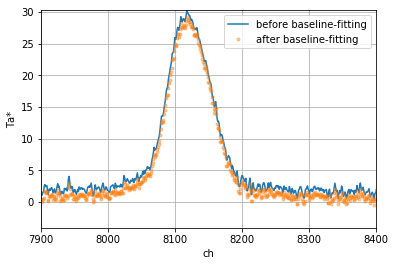

In [29]:
%matplotlib inline
plt.plot(origin, label="before baseline-fitting")#before chopper wheel
plt.plot(data_on[i], ".", label="after baseline-fitting", alpha=0.4)#after chopper wheel
plt.ylabel("Ta*")
plt.xlabel("ch")
plt.xlim(7900,8400)
plt.ylim(-4.1,30.25)
plt.legend()
plt.grid()

## gridÂÜÖ„ÅÆ„Éá„Éº„ÇøÊé¢Á¥¢

„ÅÇ„Çãgrid„Å´Êé°Áî®„Åô„Çã„Éá„Éº„Çø„ÅÆindex„ÇíÊ±Ç„ÇÅ„Çã

In [30]:
%time
index_list = []
for i in tqdm(range(max_scannum)):
    for j in range(max_scannum):
       # print(ragrid[i], decgrid[j])
        index1 = numpy.where((ragrid[i]-(offset/3600)<xffts[0]) & ((ragrid[i] + (offset/3600)>xffts[0])))
        index2 = numpy.where((decgrid[j]-(offset/3600)<xffts[1]) & ((decgrid[j] + (offset/3600)>xffts[1])))
        index_ = [i in index2[0] for i in index1[0]]
        index_ = numpy.array(index_)
        index_1and2 = numpy.where(index_ == True)
        index_1and2 = index1[0][index_1and2]
        index_list.append(index_1and2)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9/9 [00:00<00:00, 86.51it/s]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 ¬µs


### xffts„Éá„Éº„Çø„ÅÆÁ¢∫Ë™ç

### „Éá„Éº„Çø„Çígrid„Å´ÂÖ•„Çå„Çã

„Éá„Éº„Çø„ÅÆÈáç„Åø„Å§„Åë„ÅØ‰ª•‰∏ã
$$
    T = \frac{\sum_{n} T_n \frac{1}{\sigma_n^2}G(r_n)}{\sum_{n} \frac{1}{\sigma_n^2}G(r_n)}
$$

- ùëáÔºöÂº∑Â∫¶[K]
- ùúé Ôºörms
- ùëüÔºöpixel„Åã„Çâ„Éá„Éº„Çø„Åæ„Åß„ÅÆË∑ùÈõ¢
- ùê∫ÔºöGaussianÁ≠â

In [31]:
%%time
#cube„Éá„Éº„Çø„ÅÆ‰ΩúÊàê
#data_c = numpy.zeros((31, 31, 32768))#(ra, dec, ch)
#index_list2 = numpy.reshape(index_list, (31,31))#index list„ÅÆ2Ê¨°ÂÖÉÂåñÔºà„Åì„Çå„ÅØÂâçÂá¶ÁêÜ„Åó„Å¶„Åä„ÅèÔºâ #„Åì„Çå„ÅØÊ≠£„Åó„ÅÑ„ÅãÔºü
data_c = numpy.zeros((max_scannum, max_scannum, vlen))#(ra, dec, ch)##Ë¶ÅÊ≥®ÊÑèÔºÅÔºÅÔºÅ
index_list2 = numpy.reshape(index_list, (max_scannum, max_scannum))#index list„ÅÆ2Ê¨°ÂÖÉÂåñÔºà„Åì„Çå„ÅØÂâçÂá¶ÁêÜ„Åó„Å¶„Åä„ÅèÔºâ #„Åì„Çå„ÅØÊ≠£„Åó„ÅÑ„ÅãÔºü

## Chopper wheel„Åó„Åü„Éá„Éº„Çø„Çídatacube„Å´ÂÖ•„Çå„Çã
for i in tqdm(range(max_scannum)):#ra
    for j in range(max_scannum):#dec
        try:
            numerator_list = []#ÂàÜÂ≠ê
            denominator_list= []#ÂàÜÊØç
            for k in index_list2[i][j]:
                dist = calc_distance([ragrid[i], decgrid[j]], [xffts[0][k], xffts[1][k]])
                rms = calc_rms(data_on[k])
                weighted_data = rms_dist_weighting(data_on[k], dist, rms)
                #weighted_data = rms_dist_weighting(data_on[k], dist, 1)###RMS„Åå„ÅÜ„Åæ„ÅèÂãï„ÅÑ„Å¶„ÅÑ„Çã„Åã„ÅÆÁ¢∫Ë™ç
                numerator_list.append(weighted_data[0])
                denominator_list.append(weighted_data[1])
            data_c[i][j] = sum(numerator_list)/sum(denominator_list)
        except Exception as e:
            print("[{},{}], {}".format(i,j,e), end = "")

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9/9 [00:02<00:00,  3.19it/s]

CPU times: user 1.96 s, sys: 904 ms, total: 2.87 s
Wall time: 2.91 s


In [32]:
print(dist)
numerator_list[0]
denominator_list[4]

76.22589912720477


5.245732329925574e-06

Ë∑ùÈõ¢„ÇíËÄÉÊÖÆ„Åô„Çã„Å®...

### astropy„Åßfits„Å´Êõ∏„ÅçÂá∫„Åô

In [33]:
#3Ëª∏„ÅÆÂÖ•„ÇåÊõø„Åà„ÄÇ
data_c = numpy.swapaxes(data_c, 0,2)
print(numpy.shape(data_c))#Ëª∏„ÅÆÂÖ•„ÇåÊõø„Åà„ÅÆÁ¢∫Ë™ç

(32766, 9, 9)


„Éò„ÉÉ„ÉÄ„Éº„ÅÆ‰ΩúÊàê

In [34]:
vch = new_xx - 16384
crval3 = vch[0]*dv
print(new_xx)
print(crval3)

header_dict = {
"object": obs["object"],
"crval1": obs["lambda_on"],
"cdelt1": obs["grid"]/3600,
"crpix1": obs["N"]-1/2,#‰∏≠ÂøÉ„Éî„ÇØ„Çª„É´
"crval2": obs["beta_on"],
"cdelt2": obs["grid"]/3600,
"crpix2": obs["N"]-1/2, #‰∏≠ÂøÉ„Éî„ÇØ„Çª„É´
"cdelt3": dv,# km/s 
"crval3": crval3
}

[-1272. -1271. -1270. ... 31491. 31492. 31493.]
-2948.552


In [35]:
# temp = """
# SIMPLE  =                    T                                                  
# BITPIX  =                  -32                                                  
# NAXIS   =                    3                                                  
# NAXIS1  =                  31                                                 
# NAXIS2  =                  31                                                 
# NAXIS3  =                   32768                                                  
# OBJECT  = '{object}              '                                                  
# TELESCOP= 'NANTEN2            '                                                  
# INSTRUME= 'nasco          '                                                  
# OBSERVER= 'amigos           '                                                  
# DATE-OBS= '2007-12-30        '                                                  
# DATE-MAP= '2012-01-19        '                                                  
# BSCALE  =    0.10000000000E+01                                                  
# BZERO   =    0.00000000000E+01                                                  
# BUNIT   = 'K                 '                                                  
# EPOCH   =    0.20000000000E+04                                                  
# OBSRA   =    8.38104170000E+01                                                  
# OBSDEC  =   -5.37511100000E+00                                                  
# DATAMAX =    1.16774444580E+02                                                  
# DATAMIN =   -8.33924560547E+01                                                  
# CTYPE1  = 'RA---GLS          '                                                  
# CRVAL1  =    {crval1}                                                  
# CDELT1  =    {cdelt1}                                                  
# CRPIX1  =      {crpix1}
# CROTA1  =     0.0000000000E+00                                                  
# CTYPE2  = 'DEC--GLS          '                                                  
# CRVAL2  =   {crval2}                                                  
# CDELT2  =   {cdelt2}                                               
# CRPIX2  =     {crpix2}                                               
# CROTA2  =     0.0000000000E+00                                                  
# CTYPE3  = 'VELO-LSR          '                                                  
# CRVAL3  =    {crval3}                                                  
# CDELT3  =    {cdelt3}                                                  
# CRPIX3  =    1.00000000000E+00                                                  
# CROTA3  =    0.00000000000E+00                                                  
# BLANK   =   -1.00000000000E+00 """.format(**header_dict)

In [36]:
temp = """
SIMPLE  =                    T                                                  
BITPIX  =                  -32                                                  
NAXIS   =                    3                                                  
NAXIS1  =                  31                                                 
NAXIS2  =                  31                                                 
NAXIS3  =                   32768                                                  
OBJECT  = '{object}              '                                                  
TELESCOP= 'NANTEN2            '                                                  
INSTRUME= 'nasco          '                                                  
OBSERVER= 'amigos           '                                                  
DATE-OBS= '2007-12-30        '                                                  
DATE-MAP= '2012-01-19        '                                                  
BSCALE  =    0.10000000000E+01                                                  
BZERO   =    0.00000000000E+01                                                  
BUNIT   = 'K                 '                                                  
EPOCH   =    0.20000000000E+04                                                  
OBSRA   =    8.38104170000E+01                                                  
OBSDEC  =   -5.37511100000E+00                                                  
DATAMAX =    1.16774444580E+02                                                  
DATAMIN =   -8.33924560547E+01                                                  
CTYPE1  = 'RA---GLS          '                                                  
CRVAL1  =    {crval1}                                                  
CDELT1  =    {cdelt1}                                                  
CRPIX1  =      {crpix1}
CROTA1  =     0.0000000000E+00                                                  
CTYPE2  = 'DEC--GLS          '                                                  
CRVAL2  =   {crval2}                                                  
CDELT2  =   {cdelt2}                                               
CRPIX2  =     {crpix2}                                               
CROTA2  =     0.0000000000E+00                                                  
CTYPE3  = 'km/s          '                                                  
CRVAL3  =    {crval3}                                                  
CDELT3  =    {cdelt3}                                                  
CRPIX3  =    1.00000000000E+00                                                  
CROTA3  =    0.00000000000E+00                                                  
BLANK   =   -1.00000000000E+00 """.format(**header_dict)

In [37]:
target_header = fits.Header.fromstring(temp, sep = "\n")

In [52]:
#Êõ∏„ÅçÂá∫„Åó
hdu = fits.PrimaryHDU(data_c, target_header)
hdulist = fits.HDUList([hdu])
hdulist.writeto(os.path.join(analy_dir, "test20190906_v8.fits"), overwrite = True)

In [53]:
##Ë™≠„ÅøËæº„Åø
hdu_list = fits.open(os.path.join(analy_dir, "test20190906_v8.fits"))
hdu_r = hdu_list[0]
data = hdu_r.data
header = hdu_r.header

### OTF MAP

In [54]:
#%matplotlib notebook
%matplotlib inline
from ipywidgets import interact

def plot(i):
    plt.figure(figsize=(8, 8))
    plt.imshow(data[i].T, cmap = "gist_rainbow")
    #plt.xlabel("ra")
    #plt.ylabel("dec")
    plt.show()


interact(plot, i = (0,16000,1))

A Jupyter Widget

<function __main__.plot>

### RMS Map

In [55]:
#rms map
data_rms = numpy.swapaxes(data, 0,2)

In [56]:
numpy.mean(data_rms[0][0]**2)

131587.9878166254

In [57]:
rms_map = numpy.zeros((9,9))
for i in range(9):
    for j in range(9):
        rms_map[i][j] = numpy.sqrt(numpy.mean(data_rms[i][j]**2))

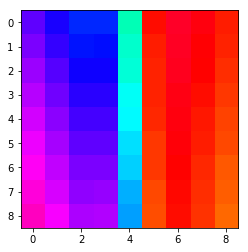

In [58]:
plt.imshow(rms_map, cmap = "gist_rainbow")

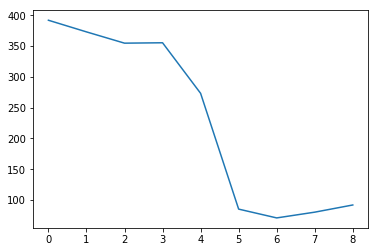

In [59]:
plt.plot(rms_map[4])

In [60]:
len(index_list2[0][8])

126

In [61]:
#bokeh  ‰Ωø„ÅÑÊñπ„ÅÇ„Çì„Åæ„Åã„Åó„Çè„Åã„Çâ„Çì
from bokeh.plotting import figure
from bokeh.io import show, output_notebook

output_notebook()
plt1 = figure()
rend1 = plt1.image(image=[data[16000]], x=0, y=0, dw =31, dh=31, palette="Plasma11")

show(plt1)

Loading BokehJS ...

(-1, 1)

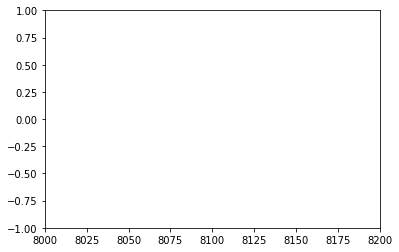

In [62]:
plt.plot(ondata[0][1][1])
plt.xlim(8000,8200)
plt.ylim(-1,1)

In [63]:
!pwd

/home/amigos/git/analy_n2data/notebook


(-2, 2)

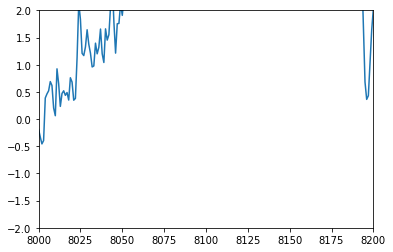

In [50]:
plt.plot(data_rms[0][0])
plt.xlim(8000,8200)
plt.ylim(-2,2)

()


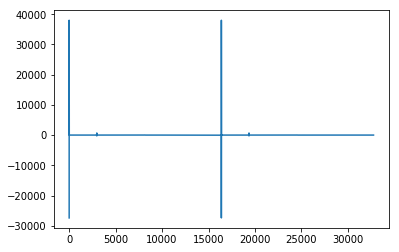

In [51]:
print(numpy.shape(data_on))
plt.plot(data_on[180])